<a href="https://colab.research.google.com/github/Ali-Ukperaj/MonteCarloIDP/blob/main/MonteCarlo1.1_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title <b>Prerequisite Setup</b>
import os
import warnings
warnings.filterwarnings("ignore")

# # delete existing files

# Download necessary files
github_folder = 'https://github.com/Ali-Ukperaj/MonteCarloIDP'
os.system(f"git clone {github_folder}")
os.system(f"mv MonteCarloIDP/* MonteCarloIDP/..")
!rm -r MonteCarlo_Files

# pip install requirements
!pip install -r requirements.txt --upgrade-strategy only-if-needed | grep -v 'already satisfied'
# !pip install MDAnalysis
# !pip install Bio

## Import Dependencies
import copy
import scipy
import numpy as np
import matplotlib.pyplot as plt

# Delta G Dependencies
import pandas as pd
from predictor import *
import joblib

# Create output folders
os.makedirs('Run_Data', exist_ok=True)
os.makedirs('Run_Data/Data', exist_ok=True)
os.makedirs('Run_Data/Plots', exist_ok=True)

## Define all paramater calculation FUNCTIONS
# Calculate SCD
def SCD_calc(Seq):
    Length = len(Seq)
    ## Calculate charge for each residue
    q_Sequence = np.array([charge[Seq[i]] for i in range(Length)])

    ## From sequences, calculate net charge, NCPR, and fraction of +/- residues
    q_Net = q_Sequence.sum()
    NCPR = q_Net / Length
    fplus = (q_Sequence > 0).mean()
    fminus = (q_Sequence < 0).mean()

    ## From sequences, calculate the sequence charge decoration (SCD)
    SCD = 0
    for i in range(1, Length):
        SCD += ((q_Sequence[i:] * q_Sequence[:-i]) * np.sqrt(i)).sum()
    SCD /= Length
    return SCD

# Calculate SHD
def SHD_calc(Seq):
    Length = len(Seq)
    ## Calculate hydropathy for each residue
    h_Sequence = np.array([hydropathy[Seq[i]] for i in range(Length)])
    ## From sequences, calculate average hydropathy
    h_Avg = h_Sequence.mean()
    std_h = np.std(h_Sequence)

    ## From sequences, calculate the sequence hydrophobicity decoration (SHD)
    SHD = 0
    for i in range(1, Length):
        SHD += ((h_Sequence[i:] + h_Sequence[:-i]) / i).sum()
    SHD /= Length
    return SHD

# Calculate SAD
def SAD_calc(Seq):
    Length = len(Seq)
    ## Calculate aromaticity for each residue
    a_Sequence = np.array([bAromatic[Seq[i]] for i in range(Length)])
    ## From sequences, calculate average aromaticity
    # a_Avg = a_Sequence.mean()
    a_Avg = a_Sequence.mean()

    ## From sequences, calculate the sequence aromatic decoration (SAD)
    SAD = 0
    for i in range(1, Length):
        SAD += ((a_Sequence[i:] * a_Sequence[:-i]) / i).sum()
    SAD /= Length
    return SAD

# Calculate delta(G)
def delta_G(seq,features,residues,nu_file):
    X = X_from_seq(seq,features,residues=residues,charge_termini=CHARGE_TERMINI,nu_file=nu_file)
    ys = models['dG'].predict(X)
    ys_m = np.mean(ys)
    return ys_m #kT

# Call previous 4 functions to calculate those paramaters, calculate composition RMSD,
# then place all of them into a single dictionary output variable
def param_calc(Seq):
    Length = len(Seq)
    # Define SCD, SHD, SAD, delta(G), and composition RMSD of the sequence
    if InputSCD == 'None':
        SCD = 'None'
    else:
        SCD = SCD_calc(Seq)
    if InputSHD == 'None':
        SHD = 'None'
    else:
        SHD = SHD_calc(Seq)

    if InputSAD == 'None':
        SAD = 'None'
    else:
        SAD = SAD_calc(Seq)

    if InputdelG == 'None':
        delG = 'None'
    else:
        delG = delta_G(Seq,features,residues,nu_file)

    # Define Composition RMSD
    if InputComp == 'None':
        Comp_RMSD = 'None'
    else:
        # Calculate fraction of each amino in the sequence tested
        Seq_Comp = {amino: ((len(np.where(np.array(Seq) == amino)[0].tolist())) / (Length)) for amino in Amino_1}
        Comp_RMSD = 0
        for amino_name, frac_amino in Composition.items():
            # Uses common dictionary keys (Amino 1-Letter Abbrev.) to compare the fraction of aminos in ideal vs input sequence
            Comp_RMSD += (Seq_Comp[amino_name] - frac_amino)**2

    params = {'SCD': SCD,
              'SHD': SHD,
              'SAD': SAD,
              'delG': delG,
              'Comp': Comp_RMSD}
    return params

# Calculate the "energy" of a single sequence by first calling the "params" function to determine parameters
def energy_func(Seq):
    global Goals

    # Params is array with following format: [SCD, SHD, SAD, delG]
    params = param_calc(Seq)
    energy = 0
    for key, (goal, weight) in Goals.items():
        if params[key] != "None":
            energy += weight*(abs(params[key] - goal))

    # create temporary array that stores fraction of energy
    fract_energy = {}
    tot_energy = {}
    for key, (goal, weight) in Goals.items():
        if params[key] != 'None':
            fract_energy[key] = (weight*(abs(params[key] - goal)))/energy
            tot_energy[key] = (weight*(abs(params[key] - goal)))

    return energy, fract_energy, tot_energy

# Calculate the Metropolis criterion by inputting two sequences, then using the energy function to determine the energy of each
def Metropolis(Seq0, SeqMut):
    k_B = 1
    T = 10**(-2)
    energy0 = energy_func(Seq0)[0]
    energyMut = energy_func(SeqMut)[0]
    deltaE = energyMut - energy0
    Metrop = scipy.special.expit(-deltaE/(k_B*T))
    return Metrop

## Define move set FUNCTIONS
# Function that will mutate a single residue in the input sequence
def seq_mut(Seq):
    # determines place in chain where mutation will occur
    idx = np.random.randint(0, len(Seq))  # integer that will be the index for mutated residue in sequence
    Seq_New = copy.deepcopy(Seq[:])  # Create new sequence to not affect original input sequence
    # create new Amino list that doesn't include residue currently there
    Amino_1_New = [res for res in Amino_1 if res != Seq[idx]]
    Seq_New[idx] = np.random.choice(Amino_1_New)  # assign random residue to new sequence in determined spot
    return Seq_New

# Function that will swap the places of two residues in the input sequence
def seq_swap(Seq):
    idx1 = np.random.randint(0, len(Seq))  # integer that will be the index for mutated residue in sequence
    Amino_idx1 = Seq[idx1]
    idx2 = np.random.randint(0, len(Seq))  # integer that will be the index for mutated residue in sequence
    Amino_idx2 = Seq[idx2]
    Seq_New = copy.deepcopy(Seq[:])  # Create new sequence to not affect original input sequence
    # create new Amino list that doesn't include residue currently there
    Seq_New[idx1] = Amino_idx2
    Seq_New[idx2] = Amino_idx1
    return Seq_New

# Function that will shuffle a variable length of the sequence ranging from (3, N)
def seq_shuf(Seq):
    # Input sequence MUST be a numpy array containing a list. This is because the sequences will be indexed with another list and
    # this functionality is only possible with a numpy array
    copyShuf = copy.deepcopy(Seq[:])
    lenseq = len(Seq)
    shuf_size = np.random.randint(3, lenseq)
    shuf_start = np.random.randint(0, lenseq)
    shuf_indices = np.linspace(shuf_start, shuf_start+shuf_size-1, shuf_size)
    indices = []
    # conditional that makes indices periodic by catching out of bounds indices
    for ind in shuf_indices:
        if ind > (lenseq-1):
            indices.append(int(ind)-int(lenseq))
        else:
            indices.append(int(ind))
    Seq_New = copy.deepcopy(copyShuf[:])
    Seq_New[indices] = np.random.permutation(copyShuf[indices])
    return Seq_New

# Function that will randomly choose which sequence operation to use (also references user preferences)
def alteration(mutAmt, swpAmt, shfAmt, Seq):
    global Amino_1
    Amino_1 = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M',
               'F', 'P', 'S', 'T', 'W', 'Y', 'V']
    lowbound = 0
    upbound = mutAmt + swpAmt + shfAmt
    coin_flip = np.random.randint(lowbound, upbound)
    if (coin_flip >= lowbound) & (coin_flip < (lowbound + mutAmt)):
        New_Seq = seq_mut(Seq)
        seqIdentifier = 0  # variable used to identify what mutation occurred.
    elif (coin_flip >= (lowbound + mutAmt)) & (coin_flip < (lowbound + mutAmt + swpAmt)):
        New_Seq = seq_swap(Seq)
        seqIdentifier = 1
    elif (coin_flip >= (lowbound + mutAmt + swpAmt)) & (coin_flip < (lowbound + mutAmt + swpAmt + shfAmt)):
        New_Seq = seq_shuf(Seq)
        seqIdentifier = 2
    return New_Seq, seqIdentifier

## Define FUNCTIONS that calculate the weights used for each parameter
# Determine the weight of SHD
def SHDWt_Func(Seq, Length):
    hydropathy = np.loadtxt('AA_properties/Urry.dat', dtype=object)
    hydropathy[:, 1] = hydropathy[:, 1].astype(float)
    h_Sequence_orig = np.array([hydropathy[np.where(Seq[m] == hydropathy)[0], 1] for m in range(Length)])
    std_hyd = np.std(h_Sequence_orig)
    est_stdSHD = (0.65 * (Length ** (-0.45922))) * std_hyd
    WtSHD = 1/est_stdSHD
    return WtSHD


## Define FUNCTION used for checking the conditionals of the loop
def check_conditions():
    # Determine form of conditionals
    if len(saved_Keys) == 1:
        idx1 = saved_Keys[0]
        cond = (abs(params[idx1] - Goals[idx1][0])) > Intervals_Dict[idx1]
    elif len(saved_Keys) == 2:
        idx1, idx2 = saved_Keys[0], saved_Keys[1]
        cond = (((abs(params[idx1] - Goals[idx1][0])) > Intervals_Dict[idx1]) or
                ((abs(params[idx2] - Goals[idx2][0])) > Intervals_Dict[idx2]))
    elif len(saved_Keys) == 3:
        idx1, idx2, idx3 = saved_Keys[0], saved_Keys[1], saved_Keys[2]
        cond = ((((abs(params[idx1] - Goals[idx1][0])) > Intervals_Dict[idx1]) or
                ((abs(params[idx2] - Goals[idx2][0])) > Intervals_Dict[idx2])) or
                ((abs(params[idx3] - Goals[idx3][0])) > Intervals_Dict[idx3]))
    elif len(saved_Keys) == 4:
        idx1, idx2, idx3, idx4 = saved_Keys[0], saved_Keys[1], saved_Keys[2], saved_Keys[3]
        cond = (((((abs(params[idx1] - Goals[idx1][0])) > Intervals_Dict[idx1]) or
                 ((abs(params[idx2] - Goals[idx2][0])) > Intervals_Dict[idx2])) or
                ((abs(params[idx3] - Goals[idx3][0])) > Intervals_Dict[idx3])) or
                ((abs(params[idx4] - Goals[idx4][0])) > Intervals_Dict[idx4]))
    elif len(saved_Keys) == 5:
        idx1, idx2, idx3, idx4, idx5 = saved_Keys[0], saved_Keys[1], saved_Keys[2], saved_Keys[3], saved_Keys[4]
        cond = ((((((abs(params[idx1] - Goals[idx1][0])) > Intervals_Dict[idx1]) or
                  ((abs(params[idx2] - Goals[idx2][0])) > Intervals_Dict[idx2])) or
                 ((abs(params[idx3] - Goals[idx3][0])) > Intervals_Dict[idx3])) or
                ((abs(params[idx4] - Goals[idx4][0])) > Intervals_Dict[idx4])) or
                ((abs(params[idx5] - Goals[idx5][0])) > Intervals_Dict[idx5]))
    return cond

## Define general information needed to run processes
# General residue information
Amino_1 = ['A','R','N','D','C','Q','E','G','H','I','L','K','M', 'F','P','S','T','W','Y','V']
Amino_3 = ["Ala","Arg","Asn","Asp","Cys","Gln","Glu","Gly","His","Ile","Leu","Lys", "Met","Phe","Pro","Ser","Thr","Trp","Tyr","Val"]
hydropathy = np.loadtxt('AA_properties/Urry.dat', dtype=object)
hydropathy[:, 1] = hydropathy[:, 1].astype(float)
S = np.loadtxt('AA_properties/Saltout.dat', dtype=object)
S[:, 1] = S[:, 1].astype(float)
c_salt = 0.1
hydropathy[:, 1] = hydropathy[:, 1] + (S[:, 1] * (c_salt - 0.1))
hydropathy = dict(hydropathy)
charge = np.loadtxt('AA_properties/charges.dat', dtype=object)
charge[:, 1] = charge[:, 1].astype(float)
charge = dict(charge)
mass = np.loadtxt('AA_properties/masses.dat', dtype=object)
mass[:, 1] = mass[:, 1].astype(float)
mass = dict(mass)
bAromatic = {"A": 0, "C": 0, "D": 0, "E": 0, "F": 1, "G": 0, "H": 1, "I": 0, "K": 0, "L": 0, "M": 0, "N": 0, "P": 0, "Q": 0, "R": 0,
             "S": 0, "T": 0, "V": 0, "W": 1, "Y": 1}

# Information needed for delta(G) calculation
residues = pd.read_csv('residues.csv').set_index('one')   # residue.csv must be in the same directory as this script
nu_file = 'svr_model_nu.joblib'                           # svr_model_nu.joblib must be in the same directory as this script
features = ['mean_lambda', 'faro', 'shd', 'ncpr', 'fcr', 'scd', 'ah_ij','nu_svr']

# scikit-learn gives an improper version warning
warnings.filterwarnings('ignore', category=UserWarning)
# Seq_Comp gives a deprecation warning for the way it is solved, however, it gives the right values
warnings.filterwarnings('ignore', category=DeprecationWarning)
# warnings.simplefilter("ignore")
models = {}
models['dG'] = joblib.load(f'model_dG.joblib')          # model_dG.joblib must be in the same directory as this script

rm: cannot remove 'MonteCarlo_Files': No such file or directory


If looking to make a specific sequence more prone to phase separation or create a phase separating version with similar composition to a given protein, input a specific reference sequence with the desired length you’d like your final protein sequence to be.

If this does not apply to you, leave the input blank and the algorithm will randomly generate a starting sequence that is favorable to your desired properties. The main difference here is that in the later option there is no need to maintain compositional integrity when making alterations to the sequence.


In [3]:
#@title <b>Inputs</b>

## INPUT a reference sequence and/or desired length of output/resultant sequence

#@markdown Input the sequence you'd like to optimze and/or the desired length of your resultant sequence. You must have at least one input for "Ideal_Seq" or "DesLength". If you do not have a preference for one parameter, write None.
# Optionally determine a reference input sequence (if none, composition RMSD goal does not exist)
# Insert Ideal Input or "None" if None
Ideal_Seq = "YHRMAQFNVTGRGVNGCENSNGGRVGRDCSSQRNQKEEDGKEGREKEEKEAETEQDKKRDKDREEKTMDRNEEATDTRIRDNQGMKSQMGCILPRMCLCH" # @param {"type":"string","placeholder":""}

if Ideal_Seq != "None":
    Ideal_Seq = list(Ideal_Seq)
    Inp_SeqLength = len(Ideal_Seq)

# Insert desired length of output/goal sequence. MUST have (atleast) either an input reference sequence OR input desired length
DesLength = "100" # @param {"type":"string","placeholder":"None"}

if (DesLength == "None") & (Ideal_Seq == "None"):
    print("WARNING: You must enter an input for DesLength, IdealSeq, or both.")

# If desired length not explicitly specified, assume same size as input reference sequence.
if DesLength == "None":
    DesLength = Inp_SeqLength
else:
    DesLength = int(DesLength)

# Define Comp_Goal and composition of sequence depending on input Ideal_Seq
if Ideal_Seq == "None":
    Composition = 'None'
    Comp_Goal = 'None'
    Inp_SeqLength = DesLength
else:
    # Create a dictionary composition by finding the fraction of each amino acid in the reference sequence (n_amino/n_total)
    Composition = {amino: (len(np.where(np.array(Ideal_Seq) == amino)[0].tolist()))/(Inp_SeqLength) for amino in Amino_1}
    Comp_Goal = 0

#@markdown Input desired values of parameters for optimized sequence. If you do not want a parameter to be included in optimization, write None.
## INPUT parameter goal values.
SCD_Goal = "-0.5" # @param {"type":"string","placeholder":"1"}
SHD_Goal = "3.9" # @param {"type":"string","placeholder":"1"}
SAD_Goal = "None" # @param {"type":"string","placeholder":"1"}
delG_Goal = "None" # @param {"type":"string","placeholder":"1"}

if SCD_Goal != "None":
    SCD_Goal = float(SCD_Goal)
if SHD_Goal != "None":
    SHD_Goal = float(SHD_Goal)
if SAD_Goal != "None":
    SAD_Goal = float(SAD_Goal)
if delG_Goal != "None":
    delG_Goal = float(delG_Goal)
Goal_Array = [SCD_Goal, SHD_Goal, SAD_Goal, delG_Goal, Comp_Goal]

#@markdown Input parameter weights (how important each parameter is to your goal). If you do not want to optimize for a given parameter, input None.
# Recommended weights are calculated for each parameter, so if you would like to run purely based on that, leave parameter weight as 1.
SCD_InputWeight = "1" # @param ["None","1","2","3"]
SHD_InputWeight = "1" # @param ["None","1","2","3"]
SAD_InputWeight = "None" # @param ["None","1","2","3"]
delG_InputWeight = "None" # @param ["None","1","2","3"]
Comp_InputWeight = "None" # @param ["None","1","2","3"]
if SCD_InputWeight != "None":
    InputSCD = int(SCD_InputWeight)
else:
    InputSCD = 'None'
if SHD_InputWeight != "None":
    InputSHD = int(SHD_InputWeight)
else:
    InputSHD = 'None'
if SAD_InputWeight != "None":
    InputSAD = int(SAD_InputWeight)
else:
    InputSAD = 'None'
if delG_InputWeight != "None":
    InputdelG = int(delG_InputWeight)
else:
    InputdelG = 'None'
if Comp_InputWeight != "None":
    InputComp = int(Comp_InputWeight)
else:
    InputComp = 'None'

InputWeights = [InputSCD, InputSHD, InputSAD, InputdelG, InputComp]
InputWeightDictionary = {'SCD': InputSCD, 'SHD': InputSHD, 'SAD': InputSAD, 'delG': InputdelG, 'Comp': InputComp}

for [ind, wts] in enumerate(InputWeights):
    if (wts == "None") ^ (Goal_Array[ind] == "None"):
        print("Error: If not interested in a parameter, both your goal value and weight for that parameter must be None")

#@markdown Input desired move set frequencies and ratios. If you do not want a moveset to be used, input None.
mutRatio = "None" # @param ["None","1","2","3","4","5"]
swpRatio = "None" # @param ["None","1","2","3","4","5"]
shfRatio = "1" # @param ["None","1","2","3","4","5"]
if mutRatio != "None":
    mutRatio = int(mutRatio)
else:
    mutRatio = 0
if swpRatio != "None":
    swpRatio = int(swpRatio)
else:
    swpRatio = 0
if shfRatio != "None":
    shfRatio = int(shfRatio)
else:
    shfRatio = 0

#@markdown Input the maximum number of iterations you'd like to run the for.
desired_cycles = 10000 # @param {"type":"integer", "placeholder":"1000"}

Error: If not interested in a parameter, both your goal value and weight for that parameter must be None


In [4]:
#@title <b>Calculate Final Variables Needed and Run Loop</b>

## Calculate recommended weights based on derived formulas and then determine FINAL weights based on these and input weights
if Ideal_Seq != "None":
    SHD_Weight = SHDWt_Func(Ideal_Seq, Inp_SeqLength)/4
    SEQUENCE = Ideal_Seq.copy()
else:
    SeqTemp = np.random.choice(Amino_1, DesLength)
    SEQUENCE = SeqTemp.copy()
    SHD_Weight = SHDWt_Func(SeqTemp, DesLength)/4
SCD_Weight, SAD_Weight, delG_Weight, Comp_Weight = 0.1, 50, 100/3, 10000
CalcWeights = [SCD_Weight, SHD_Weight, SAD_Weight, delG_Weight, Comp_Weight]
SEQUENCE = str(SEQUENCE)
SEQUENCE = SEQUENCE.replace('[','').replace(']','').replace(',','').replace('\'','').replace(' ','')
CHARGE_TERMINI = True
seq = SEQUENCE
if " " in seq:
    seq = ''.join(seq.split())
    print('Blank character(s) found in the provided sequence. Sequence has been corrected, but check for integrity.')

# Initialize final weights
Weights = [0, 0, 0, 0, 0]
# Use input weight ratios to balance the calculated and input weights & define Goals + Intervals
for count, inp in enumerate(InputWeights):
    if inp == 'None':
        Weights[count] = "None"
    else:
        Weights[count] = inp*CalcWeights[count]

## Set intervals for each parameter (range within which a parameter has arrived at its goal)
Intervals = [0, 0, 0, 0, 0]
for count, goal in enumerate(Goal_Array):
    if goal == 0:
        Intervals[count] = 0.0005
    elif goal == "None":
        Intervals[count] = "None"
    else:
        Intervals[count] = abs(goal*0.0005)
Intervals_Dict = {
    'SCD': Intervals[0],
    'SHD': Intervals[1],
    'SAD': Intervals[2],
    'delG': Intervals[3],
    'Comp': Intervals[4]}

# Account for parameters that a user may not want to optimize for
# Save keys where Interval != None
saved_Keys = []
for key, inte in InputWeightDictionary.items():
    if inte != "None":
        saved_Keys.append(key)

# Place parameter goals and their associated weights in a dictionary format
Goals = {
    'SCD': [SCD_Goal, Weights[0]],
    'SHD': [SHD_Goal, Weights[1]],
    'SAD': [SAD_Goal, Weights[2]],
    'delG': [delG_Goal, Weights[3]],
    'Comp': [Comp_Goal, Weights[4]]}

## Determine a starting sequence by minimizing the energy function out of 100 randomly generated sequences
# Essentially, if you want to keep composition exactly the same as your ideal sequence, don't randomly generate starting sequence
if ((mutRatio == 0) & ((DesLength == "None") or (Ideal_Seq != "None") & (DesLength == len(Ideal_Seq)))):
  Seq = np.array(list(Ideal_Seq))
else:
  # Initialize array for saving pairs of sequences and their respective "energies"
  MinEnergySeq = np.empty(shape=[100, 2], dtype=object)
  for i in range(100):
      SeqRand = np.random.choice(Amino_1, DesLength)
      energyRand = energy_func(SeqRand)
      MinEnergySeq[i] = ["".join(SeqRand), energyRand]
  # Sequence with the minimum energy
  Seq = np.array(list(MinEnergySeq[np.argmin(MinEnergySeq[:, 1], axis=0), 0]))

# Set starting sequence's parameters
params = param_calc(Seq)
Seq_Comp = {amino: ((len(np.where(np.array(Seq) == amino)[0].tolist())) / (DesLength)) for amino in Amino_1}
SCD, SHD, SAD, delG, Comp = params['SCD'], params['SHD'], params['SAD'], params['delG'], params['Comp']

# Initialize snapshot frequency, counting variables, and the output array for tracking param movement
if (desired_cycles >= 100) & (desired_cycles % 100 == 0):
    snapshot_freq = desired_cycles//100  # how often we're tracking the progress of our parameters and sequence
elif (desired_cycles >= 100) & (desired_cycles % 100 != 0):
    snapshot_freq = 10
else:
    snapshot_freq = 1

# Set counters for number of specific types of alterations and their respective accepted changes.
mutCount, mutAccepted, swpCount, swpAccepted, shfCount, shfAccepted = 0, 0, 0, 0, 0, 0

# Will be used to store sequence and all other desired parameters
Movement = np.empty(shape=[(desired_cycles//snapshot_freq)+1, 6], dtype=object)
iterations, frame = 0, 0

# Store fraction of energy
energyFrac = np.empty(shape=[(desired_cycles)+1, 6], dtype=object)
energyTot = np.empty(shape=[(desired_cycles)+1, 6], dtype=object)

## Run loop

# Print starting sequence
print(f"Original Sequence: {''.join(Seq)}\n")

# Loop that runs until ALL parameters are within their proper interval OR iterations reaches the maximum desired # of cycles
while (check_conditions() & (iterations <= desired_cycles)):

    # Update what iteration you are on every 1/10th of the maximum amount of cycles
    if iterations % (desired_cycles/10) == 0:
        print(f"Current iteration: {iterations}\n")
    # Take "snapshot" of data every so many steps (determined previosuly)
    if iterations % snapshot_freq == 0:
        Movement[frame] = ["".join(Seq), SCD, SHD, SAD, delG, Comp]
        frame += 1  # counter keeping track of what "frame" we're currently on

    # Call functions to perform an alteration on our sequence
    Seq_New, chngIdent = alteration(mutRatio, swpRatio, shfRatio, Seq)
    # Tracking variable that will help determine if a sequence alteration has ultimately been accepted or rejected. Initialized as false.
    acceptedBool = False

    # Determine Metropolis criterion of this sequence change
    Metrop = Metropolis(Seq, Seq_New)

    # Acceptable criterion (energy has decreased)
    if Metrop >= 1:
        # Accept the change by making the "Seq" variable identical to "Seq_New"
        Seq = copy.deepcopy(Seq_New)
        # Since alteration is accepted, we must recalculate new parameters to update variables in loops conditionals.
        params = param_calc(Seq)
        SCD, SHD, SAD, delG, Comp = params['SCD'], params['SHD'], params['SAD'], params['delG'], params['Comp']
        acceptedBool = True
    # Can be accepted or rejected randomly to introduce a means of escaping local minima
    elif Metrop < 1:
        # generate another random number between 0 and 1 to determine if sequence mutation/swap is accepted
        coin_flip2 = np.random.uniform(0.0, 1.0)
        # Accept sequence alteration if this number is less than or equal to the Metropolis (accept --> coin_flip2 <= Metrop < 1)
        if coin_flip2 <= Metrop:
            Seq = copy.deepcopy(Seq_New)
            # Since alteration is accepted, we must recalculate new parameters to update variables in loops conditionals.
            params = param_calc(Seq)
            SCD, SHD, SAD, delG, Comp = params['SCD'], params['SHD'], params['SAD'], params['delG'], params['Comp']
            acceptedBool = True

    # Update move set counters based on the type of alteration executed and whether or not that alteration was accepted or rejected
    if (chngIdent == 0):
        mutCount += 1
        if (acceptedBool):
            mutAccepted += 1
    elif (chngIdent == 1):
        swpCount += 1
        if (acceptedBool):
            swpAccepted += 1
    elif (chngIdent == 2):
        shfCount += 1
        if (acceptedBool):
            shfAccepted += 1

    [fracEn, totEn] = [energy_func(Seq_New)[1], energy_func(Seq_New)[2]]
    # totEn = energy_func(Seq_New)[2]
    # energyFrac[iterations] = ["".join(Seq), fracEn["SCD"], fracEn["SHD"], fracEn["SAD"], fracEn["delG"], fracEn["Comp"]]
    # energyTot[iterations] = ["".join(Seq), totEn["SCD"], totEn["SHD"], totEn["SAD"], totEn["delG"], totEn["Comp"]]

    # Counts iterations for total number of mutations in script
    iterations += 1

# Determine total changes accepted in this loop
total_Moves = mutAccepted + swpAccepted + shfAccepted
Steps = snapshot_freq*(np.arange(0, frame, 1))

# Save information regarding all moves of the loop: [Seq, SCD, SHD, SAD, delta(G), Composition RMSD]

# Set file name by checking existing file saves so as not to overwrite a file
file_save = 'Run_Data/Data/Total_Movements'
new_save = copy.deepcopy(file_save)
count = 0
while os.path.exists(new_save):
    count += 1
    new_save = f"{file_save}{count}"
file_save = copy.deepcopy(new_save)
np.savetxt(file_save, Movement, fmt='%s', delimiter=',')

# Update count to not add a number if there is no pre-existing file with the same name
if count == 0:
    count = []

# Output array to save final sequence and resultant parameters: [Seq, SCD, SHD, SAD, delG, Composition RMSD]
output = ["".join(Seq), params['SCD'], params['SHD'], params['SAD'], params['delG'], params['Comp']]
np.savetxt(f"Run_Data/Data/Coordinates{count if count else ''}", output, fmt='%s', delimiter=',')

# Print the final sequence from this loop along with other relevant information
print(f"Final, optimized sequence: {''.join(Seq)}\n")
print(f"The number of iterations: {iterations}\n\n")
print(f"Output Array [Seq, SCD, SHD, SAD, delG, Composition RMSD]:\n {output[1:6]}")

Original Sequence: YHRMAQFNVTGRGVNGCENSNGGRVGRDCSSQRNQKEEDGKEGREKEEKEAETEQDKKRDKDREEKTMDRNEEATDTRIRDNQGMKSQMGCILPRMCLCH

Current iteration: 0

Current iteration: 1000

Current iteration: 2000

Current iteration: 3000

Current iteration: 4000

Current iteration: 5000

Current iteration: 6000

Current iteration: 7000

Current iteration: 8000

Current iteration: 9000

Current iteration: 10000

Final, optimized sequence: HVMPGLMTTTNDAIQCQHNKSDKANKDGEVERRQTEKKERERRETCEGKREEDERSEGQEGGKDKNMERCKDGQEDNRDRCGGRSQVSRCNGNIAMFMLY

The number of iterations: 10001


Output Array [Seq, SCD, SHD, SAD, delG, Composition RMSD]:
 [-0.519677188015629, 3.951349883924786, 'None', 'None', 'None']


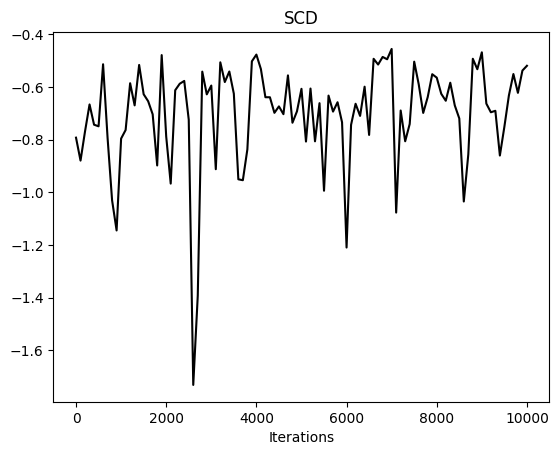

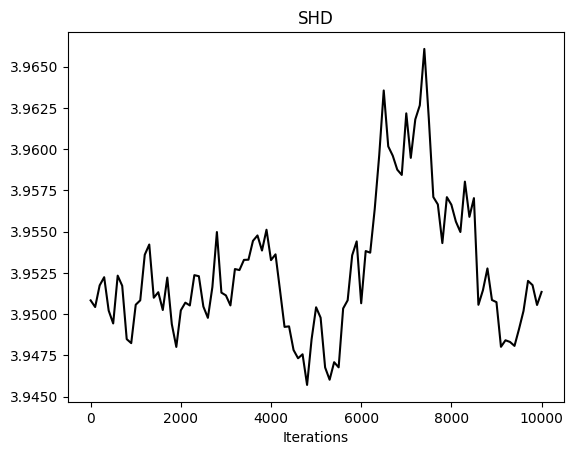

In [5]:
#@title <b>Plot movement of parameters throughout the loop</b>

# Conditional accounts for parameters that were not optimized for
if Movement[0, 1] != "None":
    plt.figure(1)
    plt.plot(Steps, Movement[:frame, 1], color='k')
    plt.title(f"SCD")
    plt.xlabel('Iterations')
    plt.savefig(f"Run_Data/Plots/SCD_plots{count if count else ''}.png")
    plt.show()

if Movement[0, 2] != "None":
    plt.figure(2)
    plt.plot(Steps, Movement[:frame, 2], color='k')
    plt.title(f"SHD")
    plt.xlabel('Iterations')
    plt.savefig(f"Run_Data/Plots/SHD_plots{count if count else ''}.png")
    plt.show()

if Movement[0, 3] != "None":
    plt.figure(3)
    plt.plot(Steps, Movement[:frame, 3], color='k')
    plt.title(f"SAD")
    plt.xlabel('Iterations')
    plt.savefig(f"Run_Data/Plots/SAD_plot{count if count else ''}.png")
    plt.show()

if Movement[0, 4] != "None":
    plt.figure(4)
    plt.plot(Steps, Movement[:frame, 4], color='k')
    plt.title(f"deltaG")
    plt.xlabel('Iterations')
    plt.savefig(f"Run_Data/Plots/deltaG_plot{count if count else ''}.png")
    plt.show()

if Movement[0, 5] != "None":
    plt.figure(5)
    plt.plot(Steps, Movement[:frame, 5], color='k')
    plt.title(f"Composition RMSD")
    plt.xlabel('Iterations')
    plt.savefig(f"Run_Data/Plots/CompRMSD_plots{count if count else ''}.png")
    plt.show()